In [1]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import pytorch_lightning as pl

pl.seed_everything(42)

Seed set to 42


42

In [2]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 32  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

In [3]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

all_trainset = torchvision.datasets.MNIST(root="/home/maxim/Documents/TestProject/maxim-lightning/mnist_diffusion",
                                         transform=transform, download=True)

# filter training imgs
# idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
# sub_trainset = torch.utils.data.Subset(all_trainset, idx)

trainloader = torch.utils.data.DataLoader(all_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=20)

In [4]:
next(iter(trainloader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

torch.Size([32, 1, 32, 32])


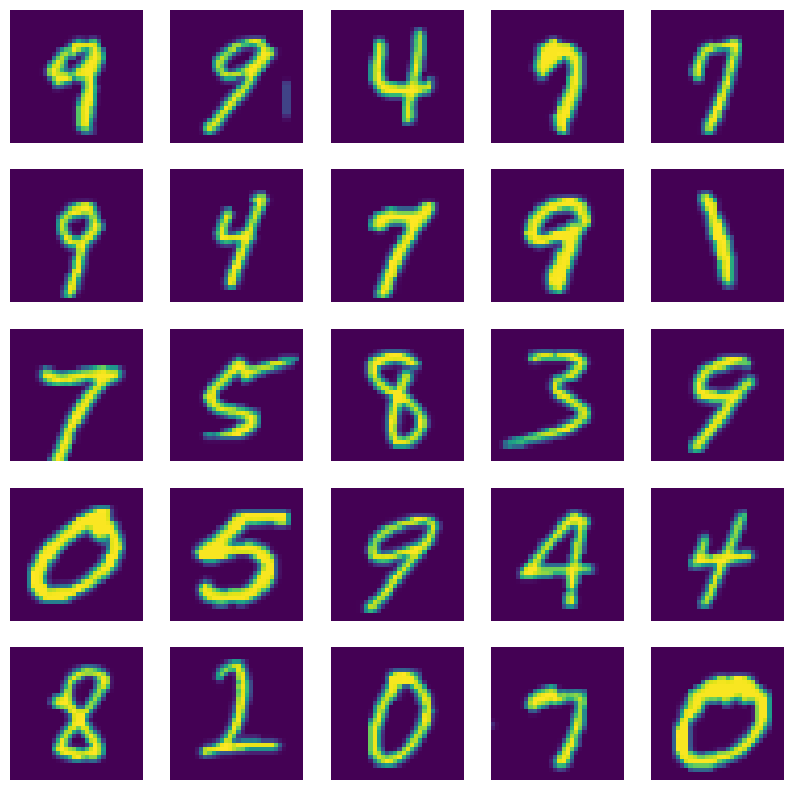

In [5]:
def cvtImg(img):
    print(img.shape)
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    imgs = cvtImg(x)
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

torch.Size([25, 1, 32, 32])


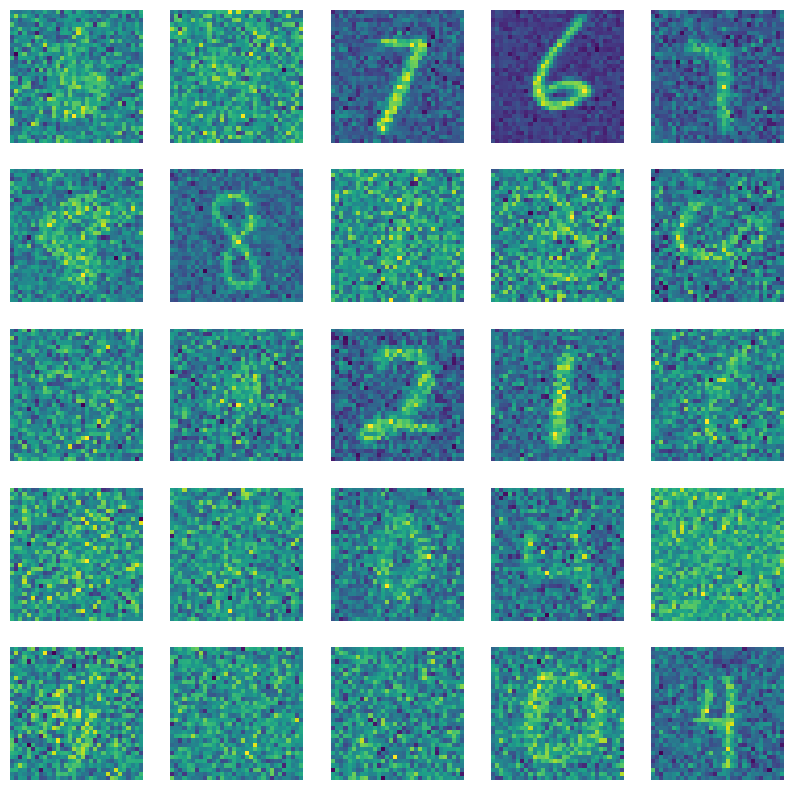

In [6]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

In [7]:
embed_dim = 4

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()
        
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(embed_dim, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [9]:
class Model(pl.LightningModule):
    def __init__(self, num_classes=None):
        super().__init__()

        self.step = 0

        self.l_ts = nn.Sequential(
            nn.Linear(1, embed_dim),
            nn.LayerNorm([embed_dim]),
            nn.ReLU(),
        )
        
        self.down_x32 = Block(in_channels=1, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)
        
        self.mlp = nn.Sequential(
            nn.Linear(2048+embed_dim, 128), #2240
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )
        
        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)
        
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, padding=0)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, embed_dim)
    
    def forward(self, x, x_ts, y):
        x_ts = self.l_ts(x_ts)

        if y is not None:
            x_ts_y = x_ts + self.label_emb(y)
        else:
            x_ts_y = x_ts

        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts_y)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)
                
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts_y], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)
        
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]
        
        for i, block in enumerate(blocks):
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            
            print(x.shape)

            x = block(x, x_ts_y)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # ----- output -----
        x = self.cnn_output(x)

        return x
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0008)
    
    def training_step(self, batch, batch_idx):
        # 32, 1, 32, 32
        x, labels = batch
        x_ts = generate_ts(len(x[0]))
        x_a, x_b = forward_noise(x[0].cpu().numpy(), x_ts)
        x_a = torch.from_numpy(x_a).cuda()
        x_b = torch.from_numpy(x_b).cuda()

        # 1, 1, 32, 32
        
        x_ts = torch.from_numpy(x_ts).view(-1, 1).float()
        x_ts = x_ts.cuda()

        x_a = x_a.float()
        x_b = x_b.float()

        # 1, 1, 32, 32

        if np.random.random() < 0.1:
            labels = None
        
        if labels == None:
            y_p = self(x_a, x_ts, labels)
        else:
            # 1, 1, 32, 32
            y_p = self(x_a, x_ts, labels[0])
            # 1, 1, 32, 32
        
        loss = torch.mean(torch.abs(y_p - x_b))

        self.step += 1

        if self.step % 250 == 0:
            self.predict_step(batch=batch, batch_idx=batch_idx)

            print(f"Step {self.step:03d} | Loss: {loss.item()}")
            
            dict = self.state_dict()

            dict["pytorch-lightning_version"] = '2.1.0'
            dict["global_step"] = 0
            dict["epoch"] = 0
            dict["state_dict"] = self.state_dict()
            print(dict["global_step"])
            torch.save(dict, "diffusion_model.ckpt")

        logs = {"loss": loss}
        return {"loss": loss, "log": logs}
    
    def predict_step(self, batch, batch_idx):
        x, labels = batch
        xs = []
        x = torch.randn(size=(8, 1, IMG_SIZE, IMG_SIZE), device=device)

        label = labels[0]

        print(label)

        with torch.no_grad():
            for i in trange(timesteps + 3):
                t = i
                x = self(x, torch.full([8, 1], t, dtype=torch.float, device=device), label)

                if i % 2 == 0:
                    xs.append(x[0].cpu())
                    # xs.append(x[0])
        xs = torch.stack(xs, dim=0)
        xs = torch.clip(xs, -1, 1)
        xs = cvtImg(xs)

        plt.figure(figsize=(20, 2))
        for i in range(len(xs)):
            plt.subplot(1, len(xs), i+1)
            plt.imshow(xs[i], cmap="gray")
            plt.title(f'{i}')
            plt.axis('off')

        plt.show()

        return xs[0]        

model = Model(num_classes=10)

In [10]:
model

Model(
  (l_ts): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (down_x32): Block(
    (conv_param): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dense_ts): Linear(in_features=4, out_features=128, bias=True)
    (layer_norm): LayerNorm((128, 32, 32), eps=1e-05, elementwise_affine=True)
  )
  (down_x16): Block(
    (conv_param): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dense_ts): Linear(in_features=4, out_features=128, bias=True)
    (layer_norm): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  )
  (down_x8): Block(
    (conv_param): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(128, 128, kernel_size=(3,

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type       | Params
-------------------------------------------
0  | l_ts       | Sequential | 16    
1  | down_x32   | Block      | 265 K 
2  | down_x16   | Block      | 361 K 
3  | down_x8    | Block      | 312 K 
4  | down_x4    | Block      | 299 K 
5  | mlp        | Sequential | 330 K 
6  | up_x4      | Block      | 373 K 
7  | up_x8      | Block      | 607 K 
8  | up_x16     | Block      | 656 K 
9  | up_x32     |

Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 3

  0%|          | 0/19 [00:00<?, ?it/s]

torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 3

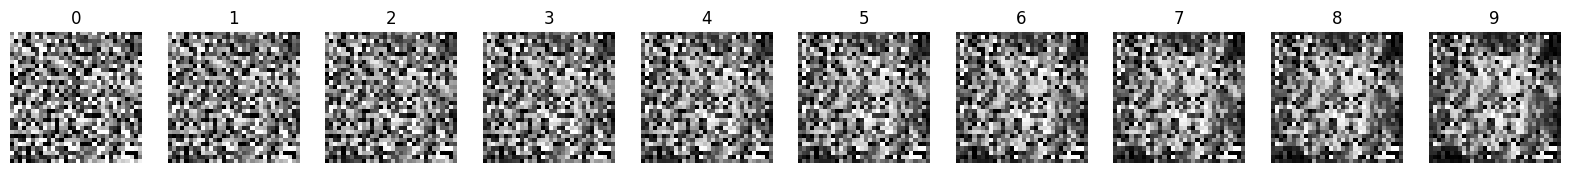

Step 250 | Loss: 0.20996710658073425
0
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size(

  0%|          | 0/19 [00:00<?, ?it/s]

torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 3

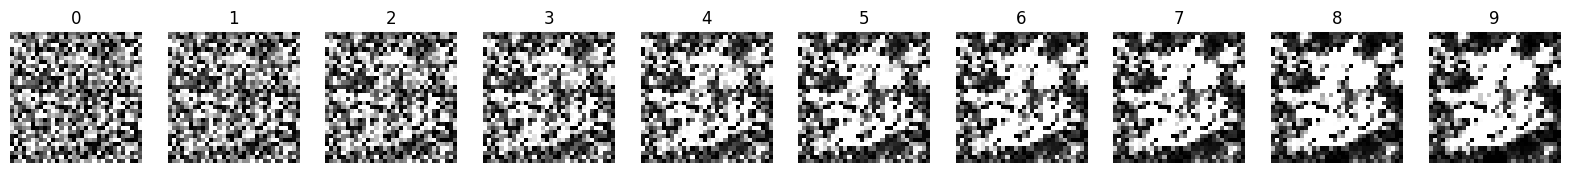

Step 500 | Loss: 0.055720094591379166
0
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size

  0%|          | 0/19 [00:00<?, ?it/s]

torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 32, 32])
torch.Size([8, 160, 4, 4])
torch.Size([8, 256, 8, 8])
torch.Size([8, 256, 16, 16])
torch.Size([8, 256, 3

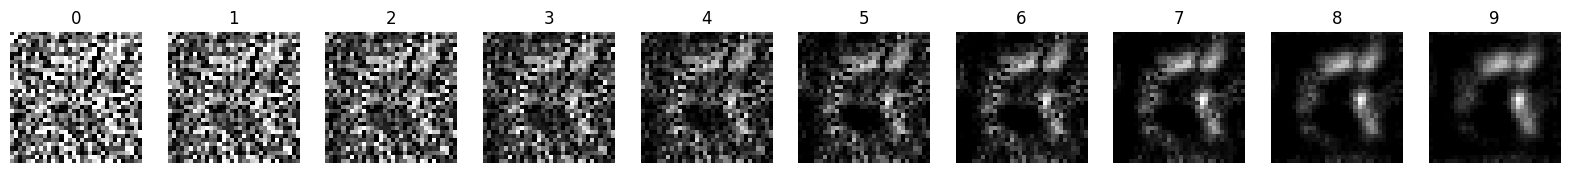

Step 750 | Loss: 0.024841584265232086
0
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 32, 32])
torch.Size([1, 160, 4, 4])
torch.Size([1, 256, 8, 8])
torch.Size

/home/maxim/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [11]:
trainer = pl.Trainer(accelerator="cuda", precision="16-mixed", max_epochs=100)

# model = Model.load_from_checkpoint('/home/maxim/Documents/TestProject/maxim-lightning/diffusion_model_Conditional_MNIST.ckpt')

trainer.fit(model, train_dataloaders=trainloader)

In [ ]:
# trainer.predict(model, trainloader)